In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pyasdf
import obspy
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel

%matplotlib inline

model = TauPyModel(model="ak135")

In [183]:
net_sta="BO.WJM"

In [184]:
from obspy.signal.util import _npts2nfft
def sync_remove_response(pre_filt, st):
    """
    mimic obspy.remove_response, but only do the frequency taper
    """
    obspy.core.util.misc.limit_numpy_fft_cache()
    for trace in st:
        data = trace.data.astype(np.float64)
        npts = len(data)
        nfft = _npts2nfft(npts)
        data = np.fft.rfft(data, n=nfft)
        t_samp = trace.stats.delta
        fy = 1 / (t_samp * 2.0)
        freqs = np.linspace(0, fy, nfft // 2 + 1).astype(np.float64)
        freq_domain_taper = obspy.signal.invsim.cosine_sac_taper(
            freqs, flimit=pre_filt)
        data *= freq_domain_taper
        data = np.fft.irfft(data)[0:npts]
        trace.data = data

    return st


In [167]:
data=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.h5",mode="r")
sync_old=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.sync_old.h5",mode="r")

In [168]:
event = data.events[0]
origin = event.preferred_origin() or event.origins[0]
event_time = origin.time
event_latitude = origin.latitude
event_longitude = origin.longitude
event_depth=origin.depth

In [169]:
BO_WJM=data.waveforms[net_sta].raw.copy()
BO_WJM_sync=sync_old.waveforms[net_sta].sync.copy()

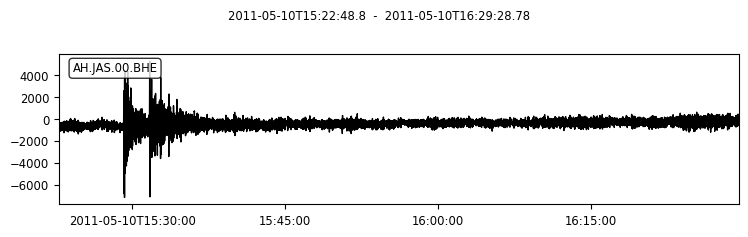

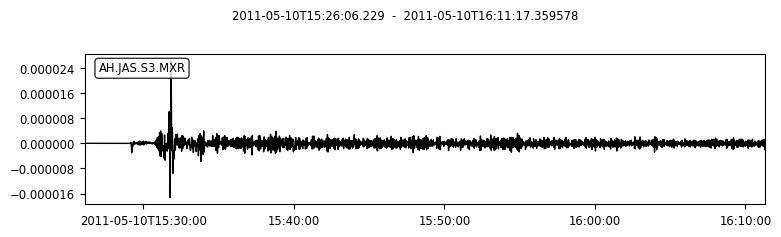

         network: AH
         station: JAS
        location: 00
         channel: BHE
       starttime: 2011-05-10T15:22:48.800000Z
         endtime: 2011-05-10T16:29:28.780000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 399999
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.2', 'event_ids': [ResourceIdentifier(id="smi:local/cmtsolution/201105101526A/event")], 'tag': 'raw'})

In [170]:
BO_WJM[0].plot();
BO_WJM_sync[0].plot();
BO_WJM[0].stats

In [171]:
BO_WJM.trim(event_time,event_time+1800)
BO_WJM_sync.trim(event_time,event_time+1800)

3 Trace(s) in Stream:
AH.JAS.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
AH.JAS.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
AH.JAS.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples

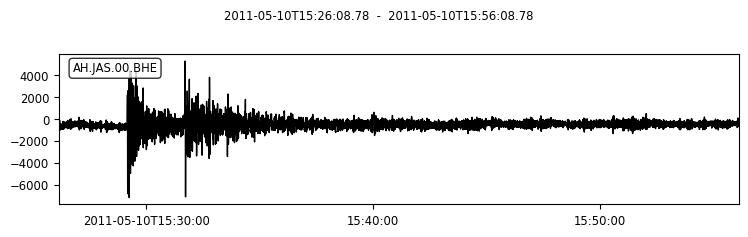

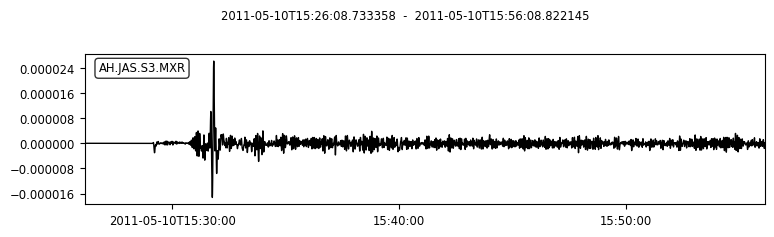

         network: AH
         station: JAS
        location: 00
         channel: BHE
       starttime: 2011-05-10T15:26:08.780000Z
         endtime: 2011-05-10T15:56:08.780000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 180001
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.2', 'event_ids': [ResourceIdentifier(id="smi:local/cmtsolution/201105101526A/event")], 'tag': 'raw'})
      processing: ['ObsPy 1.1.1: trim(endtime=UTCDateTime(2011, 5, 10, 15, 56, 8, 780000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 5, 10, 15, 26, 8, 780000))']

In [172]:
BO_WJM[0].plot();
BO_WJM_sync[0].plot();
BO_WJM[0].stats

In [173]:
BO_WJM.detrend("demean")
BO_WJM.detrend("linear")
BO_WJM.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
AH.JAS.00.BHE | 2011-05-10T15:26:08.780000Z - 2011-05-10T15:56:08.780000Z | 100.0 Hz, 180001 samples
AH.JAS.00.BHN | 2011-05-10T15:26:08.780000Z - 2011-05-10T15:56:08.780000Z | 100.0 Hz, 180001 samples
AH.JAS.00.BHZ | 2011-05-10T15:26:08.780000Z - 2011-05-10T15:56:08.780000Z | 100.0 Hz, 180001 samples

In [174]:
BO_WJM_sync.detrend("demean")
BO_WJM_sync.detrend("linear")
BO_WJM_sync.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
AH.JAS.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
AH.JAS.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples
AH.JAS.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.822145Z | 9.2 Hz, 16533 samples

In [175]:
inv=data.waveforms[net_sta].StationXML

In [176]:
max_period=100
min_period=40
f2 = 1.0 / max_period
f3 = 1.0 / min_period
f1 = 0.5 * f2
f4 = 2.0 * f3
pre_filt = (f1, f2, f3, f4)

In [177]:
BO_WJM.interpolate(sampling_rate=10)
BO_WJM_sync.interpolate(sampling_rate=10)

3 Trace(s) in Stream:
AH.JAS.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
AH.JAS.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
AH.JAS.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

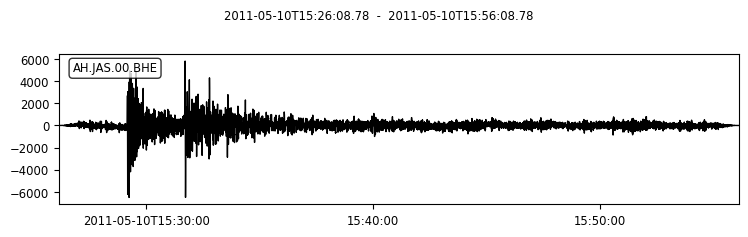

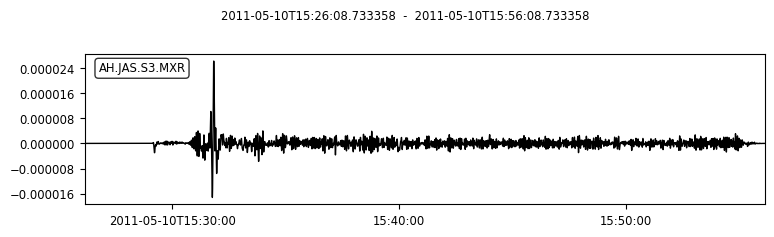

         network: AH
         station: JAS
        location: 00
         channel: BHE
       starttime: 2011-05-10T15:26:08.780000Z
         endtime: 2011-05-10T15:56:08.780000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 18001
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.2', 'event_ids': [ResourceIdentifier(id="smi:local/cmtsolution/201105101526A/event")], 'tag': 'raw'})
      processing: ['ObsPy 1.1.1: trim(endtime=UTCDateTime(2011, 5, 10, 15, 56, 8, 780000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 5, 10, 15, 26, 8, 780000))', "ObsPy 1.1.1: detrend(options={}::type='demean')", "ObsPy 1.1.1: detrend(options={}::type='linear')", "ObsPy 1.1.1: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.1.1: interpolate(args=()::method='weighted_average_slopes'::npts=None::sampling_rate=10::starttime=None::time_shift=0.0)"]

In [178]:
BO_WJM[0].plot();
BO_WJM_sync[0].plot();
BO_WJM[0].stats

In [179]:
BO_WJM.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
BO_WJM_sync=sync_remove_response(pre_filt, BO_WJM_sync)

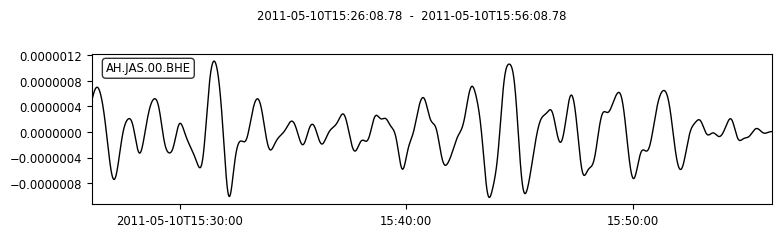

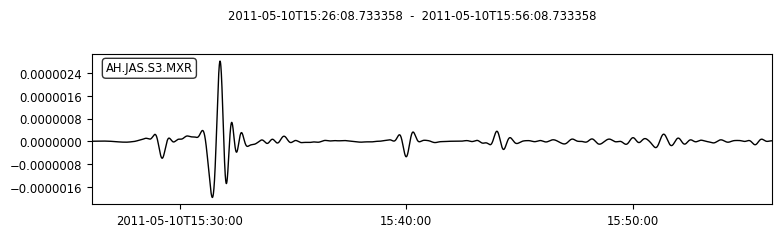

         network: AH
         station: JAS
        location: 00
         channel: BHE
       starttime: 2011-05-10T15:26:08.780000Z
         endtime: 2011-05-10T15:56:08.780000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 18001
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.2', 'event_ids': [ResourceIdentifier(id="smi:local/cmtsolution/201105101526A/event")], 'tag': 'raw'})
      processing: ['ObsPy 1.1.1: trim(endtime=UTCDateTime(2011, 5, 10, 15, 56, 8, 780000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 5, 10, 15, 26, 8, 780000))', "ObsPy 1.1.1: detrend(options={}::type='demean')", "ObsPy 1.1.1: detrend(options={}::type='linear')", "ObsPy 1.1.1: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.1.1: interpolate(args=()::method='weighted_average_slopes'::npts=None::sampling_rate=10::starttime=None::time_shift=0.0)", "ObsPy 1.1.1: remove_response(fig=No

In [180]:
BO_WJM[0].plot();
BO_WJM_sync[0].plot();
BO_WJM[0].stats

In [152]:
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                         event_latitude, event_longitude)
baz = np.mod(baz, 360)
BO_WJM.rotate(method="NE->RT", back_azimuth=baz)

3 Trace(s) in Stream:
BO.KNY..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples
BO.KNY..BHR | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples
BO.KNY..BHZ | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:56:08.800000Z | 10.0 Hz, 18001 samples

In [153]:
BO_WJM.detrend("demean")
BO_WJM.detrend("linear")
BO_WJM.taper(max_percentage=0.05,type="hann")
BO_WJM_sync.detrend("demean")
BO_WJM_sync.detrend("linear")
BO_WJM_sync.taper(max_percentage=0.05,type="hann")

3 Trace(s) in Stream:
BO.KNY.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.KNY.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.KNY.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

In [154]:
BO_WJM.filter("bandpass",freqmin=1/100,freqmax=1/40,corners=2,zerophase=True)
BO_WJM_sync.filter("bandpass",freqmin=1/100,freqmax=1/40,corners=2,zerophase=True)

3 Trace(s) in Stream:
BO.KNY.S3.MXR | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.KNY.S3.MXT | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples
BO.KNY.S3.MXZ | 2011-05-10T15:26:08.733358Z - 2011-05-10T15:56:08.733358Z | 10.0 Hz, 18001 samples

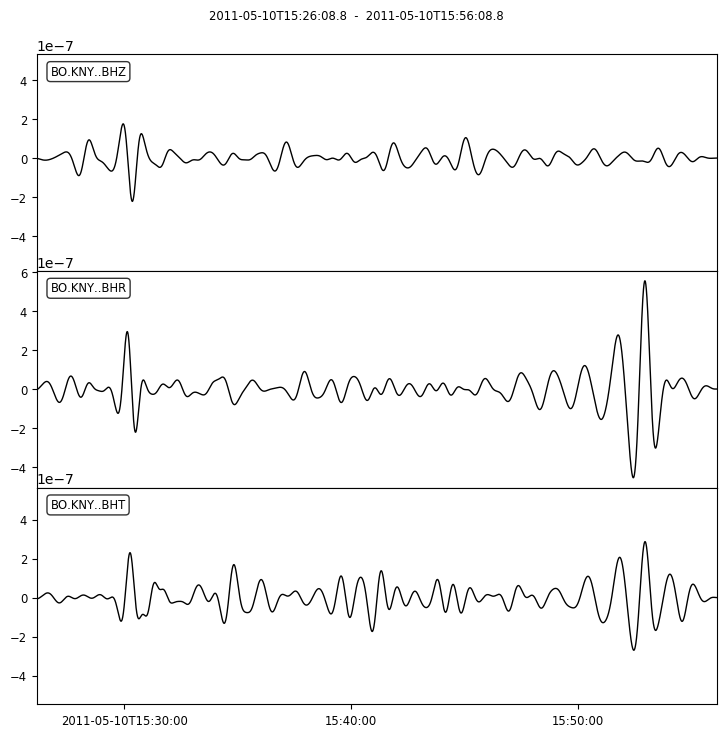

In [155]:
BO_WJM.plot();

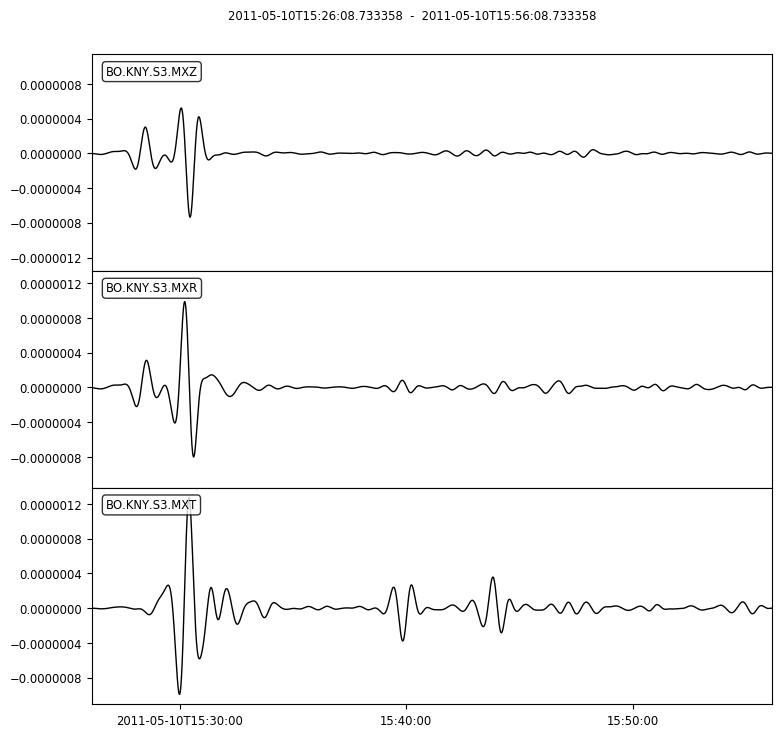

In [156]:
BO_WJM_sync.plot();

In [181]:
inv

Inventory created at 2019-08-12T19:29:51.321573Z
	Created by: ObsPy 1.1.1
		    https://www.obspy.org
	Sending institution: ObsPy 1.1.1,ObsPy's obspy.io.xseed version 1.1.1
	Contains:
		Networks (1):
			AH
		Stations (1):
			AH.JAS (Jiashan,Anhui Province)
		Channels (3):
			AH.JAS.00.BHZ, AH.JAS.00.BHN, AH.JAS.00.BHE

In [186]:
processed_data=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.preprocessed_40s_to_120s.h5",mode="r")

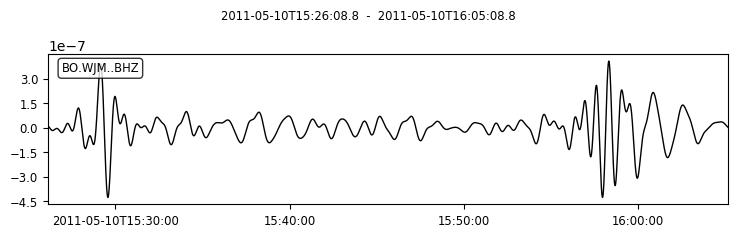

In [190]:
processed_data.waveforms[net_sta].preprocessed_40s_to_120s[2].plot();

In [191]:
processed_sync=pyasdf.ASDFDataSet("/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.sync_old.preprocessed_40s_to_120s.h5",mode="r")

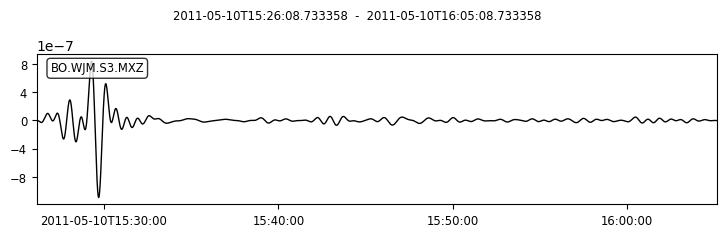

In [192]:
processed_sync.waveforms[net_sta].preprocessed_40s_to_120s[2].plot();